After messing with clustering and HMM. Let's revert back to a deterministic algoritm. Bounding boxes. Entries, exits. Time in boxes.

In [1]:
import geopandas
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load airport data, load flight data, create df

In [2]:
airports = pd.read_csv("/Users/JO/PhD/hemspy/data/helipad-data/raw-data/helipad-coordinates.csv", sep=";")
airports_gdf = geopandas.GeoDataFrame(airports, geometry=geopandas.points_from_xy(airports.longitude, airports.latitude), crs="EPSG:4326")
airports_gdf = airports_gdf.to_crs("EPSG:32634") #to metric coords
airports_gdf.geometry = airports_gdf.geometry.buffer(distance=airports.radius)
airports_gdf = airports_gdf.to_crs("EPSG:4326") #back to conventional

flights_path = '/Users/JO/PhD/hemspy/data/fr24-data/raw-data-unzipped-rearranged/flights'
flights_files = [f for f in os.listdir(flights_path) if f.endswith('.csv')]

flights_df_list, positions_df_list = [], []
for file in flights_files:
    flights_df_list.append(pd.read_csv(flights_path+'/'+file))

flights_df = pd.concat(flights_df_list, ignore_index=True)
flights_df['flight_id'] = flights_df['flight_id'].astype(int)

positions_path = '/Users/JO/PhD/hemspy/data/fr24-data/raw-data-unzipped-rearranged/positions'
positions_files = [os.path.join(positions_path, file) for file in os.listdir(positions_path) if file.endswith('.csv')]

# List to store DataFrames
positions_df_list = []

regex_pattern = r'_(.*?)\.'
regex = re.compile(regex_pattern)

# Iterate over each file
for file in positions_files:
    # Extract the flight_id from the file name
    flight_id_match = regex.search(os.path.basename(file))
    if flight_id_match:
        flight_id = flight_id_match.group(1)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file, usecols=['snapshot_id', 'altitude', 'latitude', 'longitude', 'speed'])
        
        # Add a column for flight_id
        df['flight_id'] = flight_id
        
        # Append the DataFrame to the list
        positions_df_list.append(df)

# Combine all DataFrames into a single DataFrame
positions_df = pd.concat(positions_df_list, ignore_index=True)

positions_df['flight_id'] = positions_df['flight_id'].astype(int)

d = pd.merge(positions_df, flights_df, on='flight_id', how='left')

d['UTC'] = pd.to_datetime(d['snapshot_id'], unit='s', utc=True)
d['date'] = d['UTC'].dt.date
d['year'] = d['UTC'].dt.year

d = d[d['equip'].isin(['EC45', 'A139', 'A169', 'S76', 'AS65'])]
# drop sthlm, and HMF
d = d[~(d['reg'].isin(['SEJSR', 'SEJSP', 'SEJRH', 'SEJRI', 'SERJR', 'SEJRK', 'SEJRL', 'SEJRM', 'SEJRN']))]

d = geopandas.GeoDataFrame(d, geometry=geopandas.points_from_xy(d.longitude, d.latitude), crs="EPSG:4326")
d = geopandas.sjoin(d, airports_gdf, how="left", predicate="within")

d.drop(['index_right', 'icao', 'is_primary_helipad', 'latitude_right', 'reserved', 'flight', 'callsign', 'longitude_right', 'real_to', 'schd_from', 'schd_to'], axis=1, inplace=True)
d = d.groupby('aircraft_id').apply(lambda x: x.sort_values('UTC'), include_groups=False)

## 2. Infer transitions in and out of zones, keep only rows with "movements"

In [3]:
# Identify transitions into and out of helipad zones
d['in_helipad_zone'] = ~d['zone_name'].isna()
d['zone_change'] = d['in_helipad_zone'].ne(d['in_helipad_zone'].shift())
# Extract the entry and exit times
d['entry'] = (d['zone_change'] == True) & (d['in_helipad_zone'] == True)
d['exit'] = (d['zone_change'] == True) & (d['in_helipad_zone'] == False)
d['UTC_str'] = d['UTC'].astype(str)
# Keep only entries and exits
entries_and_exits = d[d['entry'] | d['exit']]
entries_and_exits = entries_and_exits.reset_index().drop(columns='level_1')
# Create columm for UTC_out of landing zone
def UTC_out(x):
    return x.shift(-1)['UTC']
utc_out = entries_and_exits.groupby('aircraft_id').apply(lambda x: UTC_out(x), include_groups=False)
utc_out = utc_out.reset_index(drop=True)
entries_and_exits['UTC_out'] = utc_out

# Keep only the zone dwellings with time longer > min_dwell_time
min_dwell_time = 15
entries_and_exits['time_in_zone'] = (entries_and_exits['in_helipad_zone'] * (entries_and_exits['UTC_out'] - entries_and_exits['UTC'])).dt.seconds / 60
entries_and_exits = entries_and_exits[entries_and_exits['time_in_zone'] > min_dwell_time]

# Clean up primary hospital row
entries_and_exits['is_primary_hospital'] = entries_and_exits['is_primary_hospital'].map({1: True, 0: False})

## 3. Make a dataframe with transfers only

In [4]:
# Identify primary -> tertiary transfers within a time frame, assign ID number

def find_transfers(df, time_window_hours):
    df['transfer_id'] = np.nan  # Initialize the transfer_id column

    # Filter for primary and university hospital landings
    df_primary = df[df['is_primary_hospital']]
    df_university = df[~df['is_primary_hospital']]

    transfer_id = 0

    # Iterate over each primary hospital landing
    for idx_primary, row_primary in df_primary.iterrows():
        # Find matching university hospital landings for the same aircraft within the time window
        valid_university_landings = df_university[
            (df_university['aircraft_id'] == row_primary['aircraft_id']) &
            (df_university['UTC'] >= row_primary['UTC_out']) &
            (df_university['UTC'] <= row_primary['UTC_out'] + pd.Timedelta(hours=time_window_hours))
        ]

        if not valid_university_landings.empty:
            # Pick the first valid university landing
            first_valid_idx = valid_university_landings.index[0]
            transfer_id += 1
            df.at[idx_primary, 'transfer_id'] = transfer_id
            df.at[first_valid_idx, 'transfer_id'] = transfer_id

    return df

In [5]:
max_transit_time = 2.5
res = find_transfers(df=entries_and_exits, time_window_hours=max_transit_time)
transfers = res.dropna(subset='transfer_id')

In [6]:
# Make a new df with one transfer per row
## Split into sending and receiving dataframe
transfers_sending = transfers[transfers['is_primary_hospital'] == True]
transfer_receiving = transfers[transfers['is_primary_hospital'] == False]
## Left join in transfer id, remove columns
transfers_merged = pd.merge(transfers_sending, transfer_receiving, on='transfer_id', suffixes=('_sending', '_receiving'))
final = transfers_merged[['transfer_id', 'hospital_name_sending', 'ambulance_meetup_sending', 'hospital_name_receiving', 'year_sending', 
'reg_sending', 'UTC_sending', 'UTC_out_sending', 'time_in_zone_sending', 'UTC_receiving', 'zone_name_sending','zone_name_receiving', 'flight_id_receiving', 'aircraft_id_receiving']]
## Calculate transit time (this will be the time from exiting a zone to entering a zone)
final['transit_time'] = (final['UTC_receiving'] - final['UTC_out_sending']).dt.total_seconds() / 60


/var/folders/s_/hnbjtb757x10k0pyf6_x_9mw0000gn/T/ipykernel_86537/2351814565.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['transit_time'] = (final['UTC_receiving'] - final['UTC_out_sending']).dt.total_seconds() / 60


In [7]:
len(final), final.transfer_id.nunique()

(8072, 8072)

## 4. Plot a transfer

In [8]:
# This function takes a transfer and from the raw data plots all flights for that aircraft within the times of starting the transfer
# and ending it, i.e. if needed all legs will be included
def plot_transfer(raw_df, transfer_df, transfer_id):
    transfer = transfer_df[transfer_df['transfer_id'] == transfer_id]
    aircraft = transfer['aircraft_id_receiving'].iloc[0]
    start_time = transfer['UTC_out_sending'].iloc[0]
    end_time = transfer['UTC_receiving'].iloc[0]
    filtered_df = raw_df[raw_df.index.get_level_values(0) == aircraft]
    filtered_df = filtered_df[filtered_df['UTC'] > start_time]
    filtered_df = filtered_df[filtered_df['UTC'] < end_time]
    flights_set = filtered_df['flight_id'].unique()
    transfer_flights = raw_df[raw_df['flight_id'].isin(flights_set)]
    transfer_flights = transfer_flights[['geometry', 'UTC_str', 'flight_id', 'reg', 'zone_name', 'altitude', 'speed', 'snapshot_id']]
    n_legs = len(flights_set)
    return transfer_flights.explore()


In [51]:
check = np.random.choice(final.transfer_id)
plot_transfer(d, final,transfer_id=check)

In [41]:
final[final.transfer_id == check]

,transfer_id,hospital_name_sending,ambulance_meetup_sending,hospital_name_receiving,year_sending,reg_sending,UTC_sending,UTC_out_sending,time_in_zone_sending,UTC_receiving,zone_name_sending,zone_name_receiving,flight_id_receiving,aircraft_id_receiving,transit_time
7144,8530.0,Falu lasarett,0.0,Akademiska sjukhuset,2020,SEJXB,2020-09-24 13:13:01+00:00,2020-09-24 13:40:59+00:00,27.966667,2020-09-24 14:18:27+00:00,Falu lasarett,Akademiska sjukhuset,630721895,4893442,37.466667


In [18]:
from datetime import date
day = date(2019,9,9)
d[d.date == day].query("reg == 'SEJSH'").geometry.explore()

## 5. Count transfers per center and year. Filter out those early years with <2/3 of mean transfer count during years 2021-2023

In [12]:
def count_yearly_transfers(x):
    hospital = x.index
    years = [2018, 2017, 2019, 2020, 2021, 2022, 2023, 2024]
    counts = []
    for year in years:
        yearly_count = x.query(f"year_sending == {year}").transfer_id.nunique(dropna=False)
        counts.append(yearly_count)

    return pd.DataFrame({'year': years, 'transfers': counts})

In [13]:
# Calculate yearly transfers
yearly_transfers = final.groupby('hospital_name_sending').apply(lambda x: count_yearly_transfers(x), include_groups=False)
yearly_transfers = yearly_transfers.reset_index().drop(axis=1, columns='level_1')

In [14]:
def filter_years(df, threshold_proportion):
    hospitals = df['hospital_name_sending'].unique()
    result = []

    for hospital in hospitals:
        hospital_data = df[df['hospital_name_sending'] == hospital].sort_values(by='year')
        mean_2021_2023 = hospital_data[(hospital_data['year'] >= 2021) & (hospital_data['year'] <= 2023)]['transfers'].mean()
        threshold = threshold_proportion * mean_2021_2023
        
        include_rest = False
        status_list = []
        for idx, row in hospital_data.iterrows():
            if row['year'] >= 2021 or row['transfers'] >= threshold:
                include_rest = True
            status_list.append(True if include_rest else False)

        hospital_data['included'] = status_list
        result.append(hospital_data)

    return pd.concat(result)


# Assuming yearly_transfers is already defined
df_filtered = filter_years(yearly_transfers, threshold_proportion=2/3)

In [15]:
df_filtered

,hospital_name_sending,year,transfers,included
1,Alingsås lasarett,2017,1,False
0,Alingsås lasarett,2018,1,False
2,Alingsås lasarett,2019,1,False
3,Alingsås lasarett,2020,6,True
4,Alingsås lasarett,2021,5,True
...,...,...,...,...
371,Östra sjukhuset,2020,76,True
372,Östra sjukhuset,2021,79,True
373,Östra sjukhuset,2022,75,True
374,Östra sjukhuset,2023,72,True


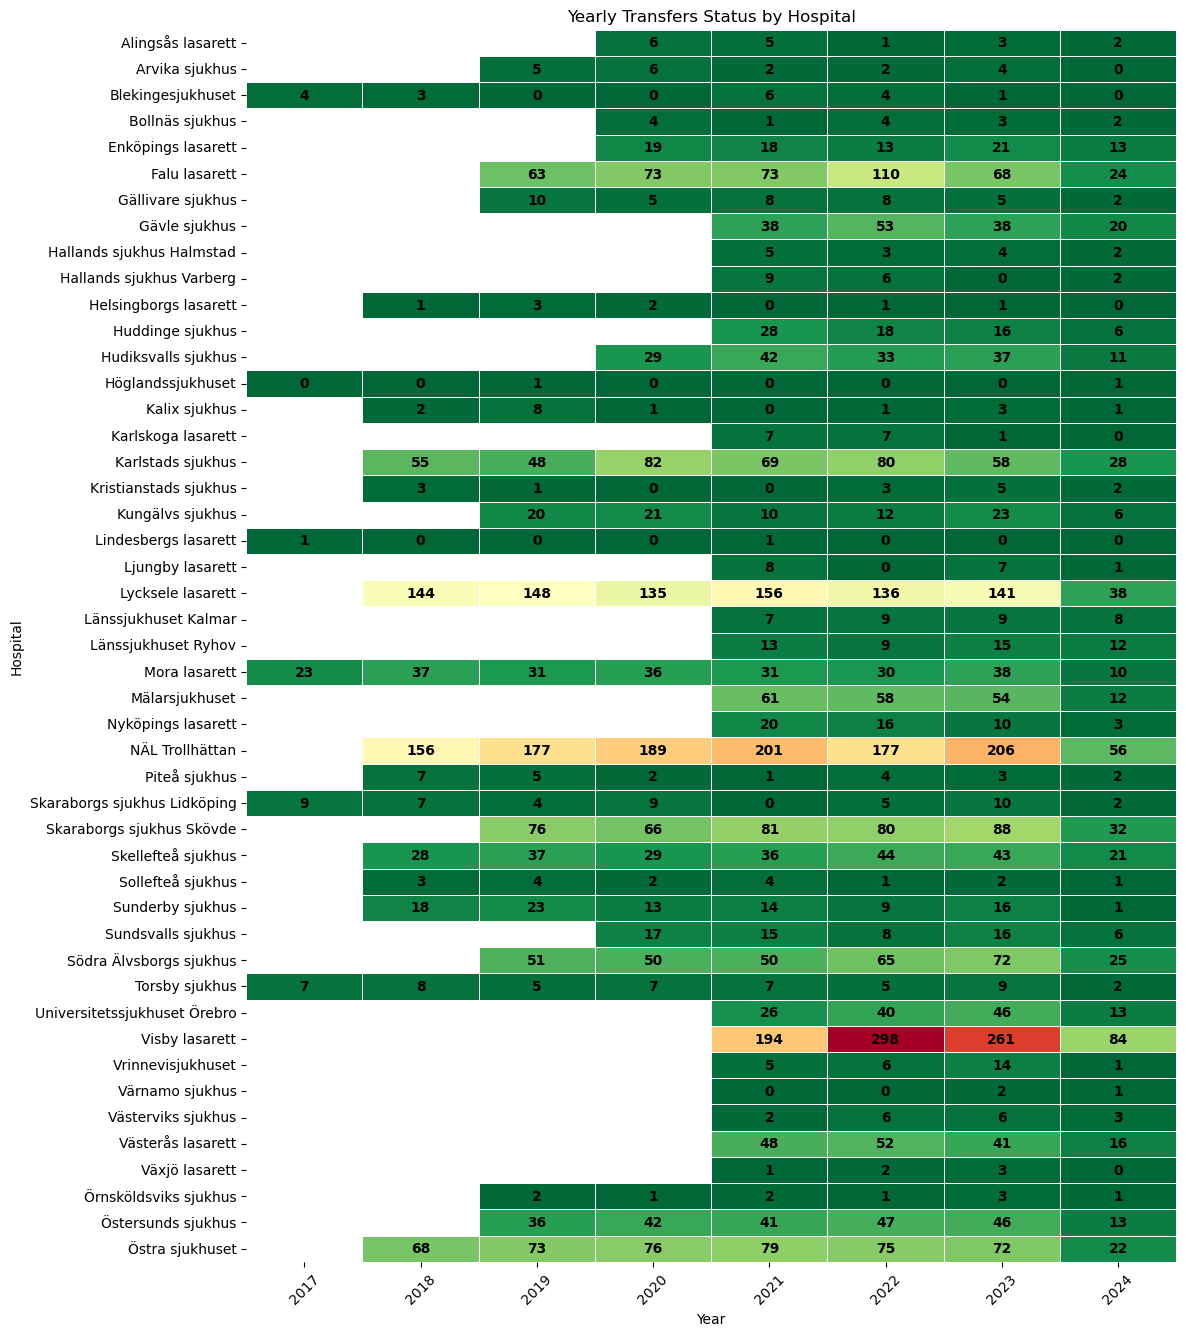

In [16]:
# Plot included years per hospital

def plot_transfers_status(df):
    # Create pivot tables for the heatmap
    pivot_table_transfers = df.pivot_table(index='hospital_name_sending', columns='year', values='transfers', aggfunc='first')
    pivot_table_status = df.pivot_table(index='hospital_name_sending', columns='year', values='included', aggfunc='first')

    # Create a mask for the heatmap based on the status
    mask = pivot_table_status.map(lambda x: x == False)

    # Plotting
    plt.figure(figsize=(12, 16))
    sns.heatmap(pivot_table_transfers, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False, linewidths=0.5,
                mask=mask, annot_kws={'size': 10, 'weight': 'bold', 'color': 'black'})

    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.title('Yearly Transfers Status by Hospital')
    plt.xlabel('Year')
    plt.ylabel('Hospital')
    plt.show()

plot_transfers_status(df_filtered)

## Summary
With this all basic functions are in place